# Assignment 01 - Perceptron

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
# Data preprocessing
dia_data_list = []
with open('Data.txt', encoding="utf-8") as f:
    for line in f:
        line = line.replace('1:','').replace('2:','').replace('3:','').replace('4:','').replace('5:','').replace('6:','').replace('7:','').replace('8:','').replace('\n','').replace('  ',' ')
        line = line.split(' ')
        line.append(1.0)           # append a '1' corresponding to b
        dia_data_list.append(list(map(float,line)))

In [3]:
dia_data = torch.tensor(dia_data_list)
dia_data

tensor([[ -1.0000,   6.0000, 148.0000,  ...,   0.6270,  50.0000,   1.0000],
        [  1.0000,   1.0000,  85.0000,  ...,   0.3510,  31.0000,   1.0000],
        [ -1.0000,   8.0000, 183.0000,  ...,   0.6720,  32.0000,   1.0000],
        ...,
        [  1.0000,   5.0000, 121.0000,  ...,   0.2450,  30.0000,   1.0000],
        [ -1.0000,   1.0000, 126.0000,  ...,   0.3490,  47.0000,   1.0000],
        [  1.0000,   1.0000,  93.0000,  ...,   0.3150,  23.0000,   1.0000]])

## 1.  Preliminary Experiment

In [4]:
X, y = make_blobs(100, n_features=2, centers = [(5,5), (10,10)], random_state = 1)   # generate a linearly separable dataset

In [5]:
zeros = np.ones(100).reshape(100,1)           # add a column of '1' corresponding to b
X = np.concatenate([X, zeros], axis = 1)

In [6]:
X_train = torch.from_numpy(X)
y_train = torch.from_numpy(y).double().reshape(100,1)
y_train[y_train==0]=-1    # replace 0 in labels by -1
lr = 1                    # set learning rate to be 1
T = 1000                  # set iter T as 1000

### 1.1  Sum Method

In [7]:
w_SUM = torch.zeros(3, dtype=float).reshape(3,1)
loss_SUM = []                                             # list of loss
mis_list_SUM = []                                         # list of the number of misclassified points
iter_count = 0
for i in range(T):
    iter_count += 1
    dist = (y_train * (X_train @ w_SUM)).double().reshape(100,1)            # X @ w * y, a vec of all distances to the plane
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).double().reshape(1,100)     # misclassified points should have negative dist
    loss = (-1) * (indi_vec @ dist)    # select all misclassified points and add the dists of them up, i.e. ∑yi(xi@w),i∈mis
    grad = ((-1) * (indi_vec @ (y_train * X_train))).reshape(3,1)        # loss=∑yi(xi@w), ∂L/∂w=grad=∑yixi,i∈mis (Li, 2022)
    loss_SUM.append(float(loss))
    mis_list_SUM.append(int(torch.sum(indi_vec)))         # number of misclassified points

    w_new = w_SUM - lr * grad
    if torch.all(w_SUM == w_new):                         # if w_SUM == w_new
        print('number of iterations:', iter_count)        # break
        break
    w_SUM = w_new                                         # else, continue
loss_SUM.pop(0)                                           # pop the initial loss and mis_list calculated by w=0
mis_list_SUM.pop(0);

number of iterations: 203


### 1.2  GD1 Method

In [8]:
w_GD1 = torch.zeros(3, dtype=float).reshape(3,1)
loss_GD1 = []
mis_list_GD1 = []
curr_i = []
iter_count = 0
for i in range(T):
    iter_count += 1                                        # the following is similar to the Sum method
    dist = (y_train * (X_train @ w_GD1)).double().reshape(100,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).double().reshape(1,100)
    loss = (-1) * (indi_vec @ dist)
    loss_GD1.append(float(loss))
    mis_list_GD1.append(int(torch.sum(indi_vec)))
    curr_i.append(i)
    if torch.all(indi_vec == 0):                           # if there is no misclassified points
        print('number of iterations:',iter_count)          # break
        break
    else:                                           
        i = int(torch.where(indi_vec.squeeze()==1)[0][0])  # else take the first misclassified point
 
    grad = ((-1) * y_train[i] * X_train[i]).reshape(3,1)   # calculate gradient only for that point
    w_new = w_GD1 - lr * grad                              # update w
    w_GD1 = w_new
loss_GD1.pop(0)
mis_list_GD1.pop(0);

number of iterations: 95


### 1.3  SGD Method

In [9]:
w_SGD = torch.zeros(3, dtype=float).reshape(3,1)

loss_SGD = []
mis_list_SGD = []
curr_i = []
iter_count = 0
for i in range(T):
    iter_count += 1                                        # the following is similar to the GD1 method
    dist = (y_train * (X_train @ w_SGD)).double().reshape(100,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).double().reshape(1,100)
    loss = (-1) * (indi_vec @ dist)
    loss_SGD.append(float(loss))
    mis_list_SGD.append(int(torch.sum(indi_vec)))
    curr_i.append(i)
    if torch.all(indi_vec == 0):
        print('number of iterations:',iter_count)
        break
    else:         # instead of taking the first misclassified point, in SGD method we randomly pick one
        i = int(np.random.choice(torch.where(indi_vec.squeeze()==1)[0]))   
    
    grad = ((-1) * y_train[i] * X_train[i]).reshape(3,1)   
    w_new = w_SGD - lr * grad
    w_SGD = w_new
loss_SGD.pop(0)
mis_list_SGD.pop(0);

number of iterations: 91


### 1.4 Results

In [10]:
x = torch.tensor(list(range(0,15)))
x_SUM = (0 - w_SUM[2] - w_SUM[1]*x) / w_SUM[0]
x_GD1 = (0 - w_GD1[2] - w_GD1[1]*x) / w_GD1[0]
x_SGD = (0 - w_SGD[2] - w_SGD[1]*x) / w_SGD[0]

Text(0, 0.5, 'y')

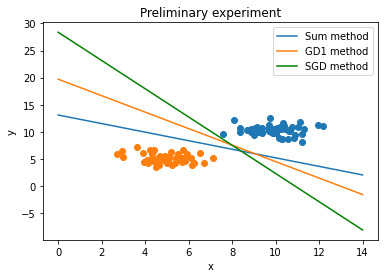

In [11]:
plt.plot(x,x_SUM, label='Sum method')
plt.plot(x,x_GD1, color = '#ff7f0e', label='GD1 method')
plt.plot(x,x_SGD, color = 'g', label='SGD method')
plt.legend(loc='best') 
plt.scatter(X[y==1][:,1], X[y==1][:,0])
plt.scatter(X[y==0][:,1], X[y==0][:,0], color = '#ff7f0e')
plt.title('Preliminary experiment')
plt.xlabel('x') 
plt.ylabel('y') 

## 2.  Initialize $w$ with $0$

In [12]:
X = dia_data[:,1:].reshape(768,9)
y = dia_data[:,0].reshape(768,1)
X_train, X_val, X_test = X.split([612,78,78])    # split data into training set, validation set, and test set 
y_train, y_val, y_test = y.split([612,78,78])    # according to the ratio of 80:10:10

In [13]:
lr = 1
T = 1000

### 2.1  Sum Method

In [14]:
w = torch.zeros(9).reshape(9,1)
loss_SUM = []
mis_list_SUM = []
w_SUM_list = []
for i in range(T):
    dist = (y_train * (X_train @ w)).reshape(612,1)      
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    grad = ((-1) * (indi_vec @ (y_train * X_train))).reshape(9,1)  
    loss_SUM.append(float(loss))
    mis_list_SUM.append(int(torch.sum(indi_vec)))
    w_new = w - lr * grad
    if torch.all(w == w_new):
        break
    w = w_new
    w_SUM_list.append(w)
loss_SUM.pop(0)
mis_list_SUM.pop(0);

### 2.2 GD1 Method

In [15]:
w = torch.zeros(9).reshape(9,1)
loss_GD1 = []
mis_list_GD1 = []
curr_i = []             # list of the current misclassified point that to be optimised
w_GD1_list = []
iter_count = 0
for i in range(T):
    iter_count += 1
    dist = (y_train * (X_train @ w)).reshape(612,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    loss_GD1.append(float(loss))
    mis_list_GD1.append(int(torch.sum(indi_vec)))    
    if torch.all(indi_vec == 0):
        print('number of iterations:',iter_count)
        break
    else:
        i = int(torch.where(indi_vec.squeeze()==1)[0][0])
        curr_i.append(i)

    grad = ((-1) * y_train[i] * X_train[i]).reshape(9,1)       
    w_new = w - lr * grad
    w = w_new
    w_GD1_list.append(w)
loss_GD1.pop(0)
mis_list_GD1.pop(0);

### 2.3  SGD Method

In [16]:
w = torch.zeros(9).reshape(9,1)
loss_SGD = []
mis_list_SGD = []
curr_i = []
w_SGD_list = []
iter_count = 0
for i in range(T):
    iter_count += 1
    dist = (y_train * (X_train @ w)).reshape(612,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    loss_SGD.append(float(loss))
    mis_list_SGD.append(int(torch.sum(indi_vec)))    
    if torch.all(indi_vec == 0):
        print('number of iterations:',iter_count)
        break
    else:
        i = int(np.random.choice(torch.where(indi_vec.squeeze()==1)[0]))
        curr_i.append(i)
  
    grad = ((-1) * y_train[i] * X_train[i]).reshape(9,1)   
    w_new = w - lr * grad
    w = w_new
    w_SGD_list.append(w)
loss_SGD.pop(0)
mis_list_SGD.pop(0);

### 2.4  Results

Text(0.5, 0, 'Iteration')

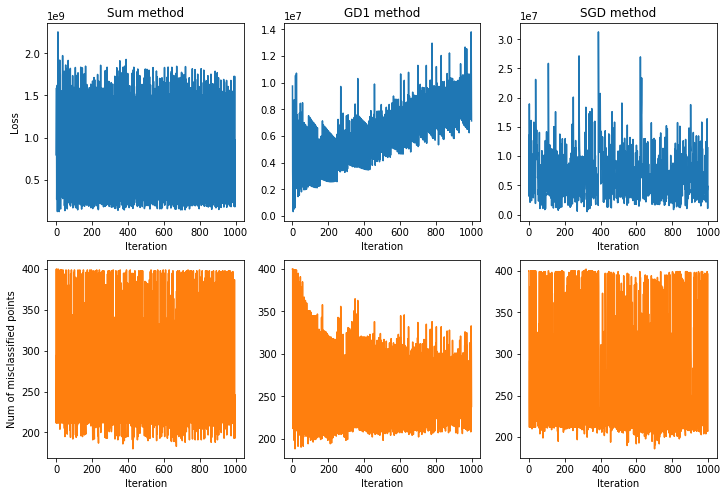

In [17]:
fig, plots = plt.subplots(2,3,figsize=(12,8))
plots[0,0].plot(loss_SUM)
plots[0,0].set_title('Sum method')
plots[0,0].set_xlabel('Iteration')                                    
plots[0,0].set_ylabel('Loss')

plots[1,0].plot(mis_list_SUM, color = '#ff7f0e')
plots[1,0].set_xlabel('Iteration')
plots[1,0].set_ylabel('Num of misclassified points')

plots[0,1].plot(loss_GD1)
plots[0,1].set_title('GD1 method') 
plots[0,1].set_xlabel('Iteration')

plots[1,1].plot(mis_list_GD1, color = '#ff7f0e')
plots[1,1].set_xlabel('Iteration')

plots[0,2].plot(loss_SGD)
plots[0,2].set_title('SGD method')
plots[0,2].set_xlabel('Iteration')

plots[1,2].plot(mis_list_SGD, color = '#ff7f0e')
plots[1,2].set_xlabel('Iteration')

In [18]:
def find_best(w_list):      # a function that can iteratively find the best w for each method
    correct_num = 0
    for w in w_list:
        res = X_val @ w                        # predict
        res[res<0] = -1                        # if res<0, than assign -1 to it
        res[res>0] = 1                         # otherwise 1
        true_count = torch.sum(res==y_val)     # compare with y_val, if res==y_val, than it is a True. Count the num of True
        if true_count>correct_num:             # if true_count is better than the previous ones
            correct_num = true_count           # then update
            best_w = w
    return best_w, correct_num

In [19]:
model_list = [w_SUM_list, w_GD1_list, w_SGD_list]
best_w_list = []
corr_num_list = []
for model in model_list:
    w, corr_num = find_best(model)
    best_w_list.append(w)
    corr_num_list.append(corr_num)
print('On the validation set:')
print('The number of correctly classified points by the best w of Sum is {}, accuracy is {}'.format(int(corr_num_list[0]), int(corr_num_list[0])/78))
print('The number of correctly classified points by the best w of GD1 is {}, accuracy is {}'.format(int(corr_num_list[1]), int(corr_num_list[1])/78))
print('The number of correctly classified points by the best w of SGD is {}, accuracy is {}'.format(int(corr_num_list[1]), int(corr_num_list[1])/78))

On the validation set:
The number of correctly classified points by the best w of Sum is 58, accuracy is 0.7435897435897436
The number of correctly classified points by the best w of GD1 is 59, accuracy is 0.7564102564102564
The number of correctly classified points by the best w of SGD is 59, accuracy is 0.7564102564102564


In [20]:
res_list = []
for best in best_w_list:    # text each w on the test set
    res = X_test @ best
    res[res<0] = -1
    res[res>0] = 1
    true_Sum = torch.sum(res==y_test)
    res_list.append(true_Sum)
print('On the test set:')
print('The number of correctly classified points by the best w of Sum is {}, accuracy is {}'.format(int(res_list[0]), int(res_list[0])/78))
print('The number of correctly classified points by the best w of GD1 is {}, accuracy is {}'.format(int(res_list[1]), int(res_list[1])/78))
print('The number of correctly classified points by the best w of SGD is {}, accuracy is {}'.format(int(res_list[1]), int(res_list[1])/78))

On the test set:
The number of correctly classified points by the best w of Sum is 48, accuracy is 0.6153846153846154
The number of correctly classified points by the best w of GD1 is 54, accuracy is 0.6923076923076923
The number of correctly classified points by the best w of SGD is 54, accuracy is 0.6923076923076923


## 3.  Initialize $w$ with pre-trained $w$

In [21]:
X = dia_data[:,1:].reshape(768,9)
y = dia_data[:,0].reshape(768,1)
X_train, X_val, X_test = X.split([612,78,78])    # split data into training set, validation set, and test set 
y_train, y_val, y_test = y.split([612,78,78])    # according to the ratio of 80:10:10

In [22]:
lr = 1
T = 100000

### 3.1  Sum Method

In [23]:
w = torch.zeros(9).reshape(9,1)
loss_SUM = []
mis_list_SUM = []
w_SUM_list = []
for i in range(T):
    dist = (y_train * (X_train @ w)).reshape(612,1)      
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    grad = ((-1) * (indi_vec @ (y_train * X_train))).reshape(9,1)  
    loss_SUM.append(float(loss))
    mis_list_SUM.append(int(torch.sum(indi_vec)))
    w_new = w - lr * grad
    if torch.all(w == w_new):
        break
    w = w_new
    w_SUM_list.append(w)
loss_SUM.pop(0)
mis_list_SUM.pop(0);

### 3.2 GD1 Method

In [24]:
#w = torch.zeros(9).reshape(9,1)
loss_GD1 = []
mis_list_GD1 = []
curr_i = []             # list of the current misclassified point that to be optimised
w_GD1_list = []
iter_count = 0
for i in range(T):
    iter_count += 1
    dist = (y_train * (X_train @ w)).reshape(612,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    loss_GD1.append(float(loss))
    mis_list_GD1.append(int(torch.sum(indi_vec)))    
    if torch.all(indi_vec == 0):
        print('number of iterations:',iter_count)
        break
    else:
        i = int(torch.where(indi_vec.squeeze()==1)[0][0])
        curr_i.append(i)

    grad = ((-1) * y_train[i] * X_train[i]).reshape(9,1)       
    w_new = w - lr * grad
    w = w_new
    w_GD1_list.append(w)
loss_GD1.pop(0)
mis_list_GD1.pop(0);

### 3.3  SGD Method

In [25]:
#w = torch.zeros(9).reshape(9,1)
loss_SGD = []
mis_list_SGD = []
curr_i = []
w_SGD_list = []
iter_count = 0
for i in range(T):
    iter_count += 1
    dist = (y_train * (X_train @ w)).reshape(612,1)     
    indi_vec = (torch.where(dist<=0, 1.0, 0.0)).reshape(1,612)
    loss = (-1) * (indi_vec @ dist)
    loss_SGD.append(float(loss))
    mis_list_SGD.append(int(torch.sum(indi_vec)))    
    if torch.all(indi_vec == 0):
        print('number of iterations:',iter_count)
        break
    else:
        i = int(np.random.choice(torch.where(indi_vec.squeeze()==1)[0]))
        curr_i.append(i)
  
    grad = ((-1) * y_train[i] * X_train[i]).reshape(9,1)   
    w_new = w - lr * grad
    w = w_new
    w_SGD_list.append(w)
loss_SGD.pop(0)
mis_list_SGD.pop(0);

### 3.4  Results

Text(0.5, 0, 'Iteration')

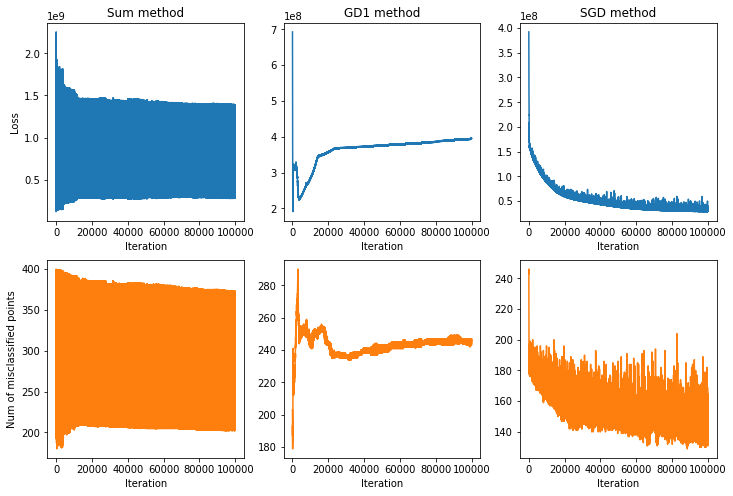

In [26]:
fig, plots = plt.subplots(2,3,figsize=(12,8))
plots[0,0].plot(loss_SUM)
plots[0,0].set_title('Sum method')
plots[0,0].set_xlabel('Iteration')                                    
plots[0,0].set_ylabel('Loss')

plots[1,0].plot(mis_list_SUM, color = '#ff7f0e')
plots[1,0].set_xlabel('Iteration')
plots[1,0].set_ylabel('Num of misclassified points')

plots[0,1].plot(loss_GD1)
plots[0,1].set_title('GD1 method') 
plots[0,1].set_xlabel('Iteration')

plots[1,1].plot(mis_list_GD1, color = '#ff7f0e')
plots[1,1].set_xlabel('Iteration')

plots[0,2].plot(loss_SGD)
plots[0,2].set_title('SGD method')
plots[0,2].set_xlabel('Iteration')

plots[1,2].plot(mis_list_SGD, color = '#ff7f0e')
plots[1,2].set_xlabel('Iteration')

In [27]:
def find_best(w_list):      # a function that can iteratively find the best w for each method
    correct_num = 0
    for w in w_list:
        res = X_val @ w                        # predict
        res[res<0] = -1                        # if res<0, than assign -1 to it
        res[res>0] = 1                         # otherwise 1
        true_count = torch.sum(res==y_val)     # compare with y_val, if res==y_val, than it is a True. Count the num of True
        if true_count>correct_num:             # if true_count is better than the previous ones
            correct_num = true_count           # then update
            best_w = w
    return best_w, correct_num

In [28]:
model_list = [w_SUM_list, w_GD1_list, w_SGD_list]
best_w_list = []
corr_num_list = []
for model in model_list:
    w, corr_num = find_best(model)
    best_w_list.append(w)
    corr_num_list.append(corr_num)
print('On the validation set:')
print('The number of correctly classified points by the best w of Sum is {}, accuracy is {}'.format(int(corr_num_list[0]), int(corr_num_list[0])/78))
print('The number of correctly classified points by the best w of GD1 is {}, accuracy is {}'.format(int(corr_num_list[1]), int(corr_num_list[1])/78))
print('The number of correctly classified points by the best w of SGD is {}, accuracy is {}'.format(int(corr_num_list[1]), int(corr_num_list[1])/78))

On the validation set:
The number of correctly classified points by the best w of Sum is 60, accuracy is 0.7692307692307693
The number of correctly classified points by the best w of GD1 is 64, accuracy is 0.8205128205128205
The number of correctly classified points by the best w of SGD is 64, accuracy is 0.8205128205128205


In [29]:
res_list = []
for best in best_w_list:    # text each w on the test set
    res = X_test @ best
    res[res<0] = -1
    res[res>0] = 1
    true_Sum = torch.sum(res==y_test)
    res_list.append(true_Sum)
print('On the test set:')
print('The number of correctly classified points by the best w of Sum is {}, accuracy is {}'.format(int(res_list[0]), int(res_list[0])/78))
print('The number of correctly classified points by the best w of GD1 is {}, accuracy is {}'.format(int(res_list[1]), int(res_list[1])/78))
print('The number of correctly classified points by the best w of SGD is {}, accuracy is {}'.format(int(res_list[1]), int(res_list[1])/78))

On the test set:
The number of correctly classified points by the best w of Sum is 55, accuracy is 0.7051282051282052
The number of correctly classified points by the best w of GD1 is 53, accuracy is 0.6794871794871795
The number of correctly classified points by the best w of SGD is 53, accuracy is 0.6794871794871795


***
CHEN Chen 29-Sep-2022